In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Reshape, Flatten, UpSampling2D, Conv2D, MaxPooling2D, Dropout

In [2]:
def visualize_images(img, num_images=5):
    total_images = len(img)
    num_rows = int(np.ceil(total_images / num_images))  # 필요한 행의 수 계산
    
    # 서브플롯 생성 (num_rows 행과 num_images 열)
    fig, axes = plt.subplots(num_rows, num_images, figsize=(num_images * 3, num_rows * 3))
    
    # 만약 num_rows가 1이라면, axes를 1차원 배열로 처리하도록 설정
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # 이미지 그리기
    for i in range(total_images):
        row = i // num_images  # 현재 행
        col = i % num_images  # 현재 열
        axes[row, col].imshow(img[i].squeeze(), cmap='gray')  # 이미지 표시
        axes[row, col].set_title(f"Image {i+1}")  # 이미지 제목 설정
        axes[row, col].axis('off')  # 축 숨기기
    
    # 남은 빈 서브플롯 숨기기
    for i in range(total_images, num_rows * num_images):
        row = i // num_images
        col = i % num_images
        axes[row, col].axis('off')  # 빈 칸은 숨기기
    
    plt.tight_layout()
    plt.show()

In [3]:
df_fdc = pd.read_excel('./data/raw/Sensor_Data_DSS_반출.xlsx')

동일값으로만 이루어진 열 확인

In [4]:
def find_constant_columns(df):
    constant_columns = {}
    for col in df.columns:
        if df[col].nunique() == 1:  
            constant_columns[col] = df[col].iloc[0] 
    return constant_columns

constant_columns = find_constant_columns(df_fdc)
print("같은 값으로 이루어진 열과 값:", constant_columns)

같은 값으로 이루어진 열과 값: {}


결측치 확인

In [5]:
def count_all_nan_rows(df):
    nan_rows_count = df.iloc[:, 5:].isna().all(axis=1).sum()
    print(f"모든 값이 NaN인 행의 개수: {nan_rows_count}")

count_all_nan_rows(df_fdc)

모든 값이 NaN인 행의 개수: 243


In [6]:
def remove_all_nan_rows(df):
    nan_rows = df.iloc[:, 5:].isna().all(axis=1)
    df_cleaned = df[~nan_rows]
    return df_cleaned

df_fdc_remove_missing = remove_all_nan_rows(df_fdc)
print(f'{df_fdc.shape} → {df_fdc_remove_missing.shape}')

(1309, 276) → (1066, 276)


In [7]:
count_all_nan_rows(df_fdc_remove_missing)

모든 값이 NaN인 행의 개수: 0


In [8]:
def get_columns_with_missing_values(df):
    missing_values = df.isnull().sum()  
    missing_columns = missing_values[missing_values > 0]
    return missing_columns

missing_columns = get_columns_with_missing_values(df_fdc_remove_missing)

In [9]:
def remove_columns_with_missing_values(df, missing_columns):
    df_cleaned = df.drop(columns=missing_columns.index)
    return df_cleaned

df_fdc_cleaned = remove_columns_with_missing_values(df_fdc_remove_missing, missing_columns)

In [10]:
no_image_list = ['ID_1231', 'ID_1233', 'ID_1239', 'ID_1241', 'ID_1244', 'ID_1245','ID_1309']
df_final = df_fdc_cleaned[~df_fdc_cleaned['ID'].isin(no_image_list)]

정규화

In [11]:
scaler =StandardScaler()

sensor_data = df_final.iloc[:,5:]
sensor_data_scaled = scaler.fit_transform(sensor_data)
df_sensor_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)
df_fdc_scaled = pd.concat([df_final.iloc[:,:5].reset_index(drop=True), df_sensor_scaled.reset_index(drop=True)], axis=1)

라벨 추출

In [12]:
labels = df_fdc_scaled['PASS(1)/FAIL(0)'].values
labels = np.array(labels)

이미지 데이터 추출 및 배열 변환

In [13]:
def get_image_filenames(image_folder, image_ids):
    image_filenames = []
    for image_id in image_ids:
        image_path = os.path.join(image_folder, f"{image_id}.png")
        if os.path.exists(image_path): 
            image_filenames.append(image_path) 
        else:
            print(f"파일을 찾을 수 없습니다: {image_id}")
    return image_filenames

image_folder = './data/image'
image_ids = df_final['ID']
image_filenames = get_image_filenames(image_folder, image_ids)

In [14]:
def compare_image_order():
    image_ids = [os.path.basename(filename).split('.')[0] for filename in image_filenames]
    comparison_result = df_final['ID'].astype(str) == image_ids

    if comparison_result.all():
        print("image_filenames의 순서와 df_final['ID']의 순서가 모두 일치합니다.")
    else:
        print("일치하지 않는 항목이 있습니다.")
        mismatch_indices = comparison_result[comparison_result == False].index
        print(f"일치하지 않는 인덱스: {mismatch_indices.tolist()}")

compare_image_order()

image_filenames의 순서와 df_final['ID']의 순서가 모두 일치합니다.


In [15]:
def image_to_numpy(file_path):
    image = Image.open(file_path).convert('L')  # Convert image to grayscale
    image = image.resize((128, 128))
    return np.array(image) / 255.0

image_data = np.array([image_to_numpy(file) for file in image_filenames])

모델

1. FDC data → Image 예측

2. Image → Scratch 분류

Train / Validation / Test

In [16]:
fdc_train, fdc_temp, img_train, img_temp = train_test_split(df_sensor_scaled, image_data, test_size=0.2, random_state=42)
fdc_val, fdc_test, img_val, img_test = train_test_split(fdc_temp, img_temp, test_size=0.25, random_state=42)

FDC data → Image 예측 모델

1. GAN

In [17]:
# # Generator 모델: FDC 데이터를 입력으로 받아 128x128 이미지 생성
# def build_generator(input_dim):
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=input_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(128 * 128, activation='tanh'))
#     model.add(layers.Reshape((128, 128, 1)))
    
#     return model

# # Discriminator 모델: 128x128 이미지를 입력으로 받아 불량/정상을 판별
# def build_discriminator(img_shape):
#     model = tf.keras.Sequential()
    
#     model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.25))
    
#     model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.25))
    
#     model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.25))
    
#     model.add(layers.Flatten())
#     model.add(layers.Dense(1, activation='sigmoid'))
    
#     return model

# # 모델 컴파일
# def compile_gan(generator, discriminator):
#     # 생성기와 판별기를 연결하는 GAN 모델
#     discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
#     discriminator.trainable = False

#     # GAN 모델은 생성기와 판별기를 결합하여 학습합니다
#     gan_input = layers.Input(shape=(fdc_train.shape[1],))
#     generated_img = generator(gan_input)
    
#     gan_output = discriminator(generated_img)
#     gan_model = tf.keras.Model(gan_input, gan_output)
#     gan_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
    
#     return gan_model

# # 하이퍼파라미터
# epochs = 100
# batch_size = 32
# input_dim = fdc_train.shape[1]
# img_shape = (128, 128, 1)

# # 모델 빌드
# generator = build_generator(input_dim)
# discriminator = build_discriminator(img_shape)
# gan_model = compile_gan(generator, discriminator)

# # 학습 함수
# def train_gan(epochs, batch_size):
#     for epoch in range(epochs):
#         # 1. Real Image를 Discriminator에 제공하여 학습
#         idx = np.random.randint(0, img_train.shape[0], batch_size)
#         real_imgs = img_train[idx]
#         real_labels = np.ones((batch_size, 1))

#         # 2. Generator가 생성한 가짜 이미지를 Discriminator에 제공하여 학습
#         noise = np.random.normal(0, 1, (batch_size, input_dim))
#         fake_imgs = generator.predict(noise)
#         fake_labels = np.zeros((batch_size, 1))

#         # Discriminator 학습
#         d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
#         d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         # Generator 학습
#         g_loss = gan_model.train_on_batch(noise, real_labels)

#         # 100 에포크마다 학습 상태 출력
#         if epoch % 100 == 0:
#             print(f"{epoch}/{epochs} [D loss: {d_loss[0]}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss}]")

# # GAN 학습 시작
# train_gan(epochs, batch_size)

# # 이미지 예측
# predicted_images = generator.predict(fdc_test)

# # 불량/정상 분류 (Scratch 여부 판정)
# predicted_class = discriminator.predict(predicted_images)

2. AutoEncoder

In [18]:
# # Encoder 모델: 입력 이미지를 잠재 공간으로 압축
# def build_encoder(input_dim):
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=input_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     # 잠재 공간 (저차원 공간) 출력
#     model.add(layers.Dense(64))  # 잠재 공간의 크기를 64로 설정
    
#     return model

# # Decoder 모델: 잠재 공간에서 128x128 이미지를 복원
# def build_decoder(latent_dim):
#     model = tf.keras.Sequential()
    
#     model.add(layers.Dense(1024, input_dim=latent_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     # 128x128 이미지로 복원
#     model.add(layers.Dense(128 * 128, activation='sigmoid'))  # 이미지 픽셀 값이 0-1 범위이므로 sigmoid 사용
#     model.add(layers.Reshape((128, 128, 1)))
    
#     return model

# # Autoencoder 모델: Encoder와 Decoder를 연결
# def build_autoencoder(input_dim, latent_dim):
#     encoder = build_encoder(input_dim)
#     decoder = build_decoder(latent_dim)
    
#     inputs = layers.Input(shape=(input_dim,))
#     encoded = encoder(inputs)
#     decoded = decoder(encoded)
    
#     autoencoder = tf.keras.Model(inputs, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')  # Autoencoder에서는 MSE(평균 제곱 오차)를 사용
#     return autoencoder

# # 하이퍼파라미터
# input_dim = fdc_train.shape[1]  # FDC 데이터의 차원
# latent_dim = 64  # 잠재 공간의 크기
# epochs = 300
# batch_size = 32

# # 모델 빌드
# autoencoder = build_autoencoder(input_dim, latent_dim)

# # 학습 함수
# def train_autoencoder(epochs, batch_size):
#     autoencoder.fit(fdc_train, img_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# # Autoencoder 학습 시작
# train_autoencoder(epochs, batch_size)

# # 이미지 예측
# predicted_images = autoencoder.predict(fdc_test)

3. Diffusion

In [19]:
# import numpy as np
# import cv2
# import tensorflow as tf
# from tensorflow.keras import layers

# # Noise scheduler (beta와 alpha 값들 생성)
# def create_beta_schedule(T, start=0.0001, end=0.02):
#     return np.linspace(start, end, T)

# # Forward process: 점진적으로 노이즈를 추가
# def forward_diffusion_process(x_0, t, beta_schedule):
#     noise = np.random.normal(size=x_0.shape)
#     alpha_t = np.prod(1 - beta_schedule[:t+1])
#     noisy_image = np.sqrt(alpha_t) * x_0 + np.sqrt(1 - alpha_t) * noise
#     return noisy_image

# # 네트워크: U-Net과 유사한 구조로 reverse process를 학습
# def build_diffusion_model(input_shape):
#     inputs = layers.Input(shape=input_shape)
    
#     # Down-sampling layers (convolutional layers)
#     x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization()(x)
    
#     # Bottleneck
#     x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
    
#     # Up-sampling layers (deconvolutional layers)
#     x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization()(x)
    
#     # Output layer: 노이즈 제거된 이미지
#     outputs = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(x)
    
#     model = tf.keras.Model(inputs, outputs)
#     return model

# # 모델 빌드
# input_shape = (128, 128, 1)  # 이미지 크기
# diffusion_model = build_diffusion_model(input_shape)

# # 모델 컴파일
# diffusion_model.compile(optimizer='adam', loss='mse')

# # 하이퍼파라미터
# epochs = 100
# batch_size = 32
# T = 1000  # Total diffusion steps
# beta_schedule = create_beta_schedule(T)  # beta 일정 생성

# # 1차원 데이터를 2차원 이미지로 변환하는 함수 (예: 128x128 크기 이미지로 변환)
# def reshape_fdc_to_image(fdc_data, target_shape=(128, 128)):
#     reshaped_images = []
#     for i in range(fdc_data.shape[0]):
#         # 1차원 데이터를 target_shape로 변환 (128x128으로 변환)
#         reshaped_img = np.resize(fdc_data[i], target_shape)
#         reshaped_images.append(reshaped_img)
    
#     # (batch_size, 128, 128, 1)로 변환 (이미지 채널 추가)
#     reshaped_images = np.expand_dims(np.array(reshaped_images), axis=-1)
#     return reshaped_images

# # Forward diffusion process를 위한 학습 함수
# def train_diffusion_model(epochs, batch_size, fdc_train, img_train):
#     for epoch in range(epochs):
#         # 각 배치마다 데이터를 섞어서 사용
#         idx = np.random.randint(0, fdc_train.shape[0], batch_size)
#         real_imgs = img_train[idx]
        
#         # T 스텝 중에서 랜덤하게 t 선택
#         t = np.random.randint(0, T)
        
#         # Forward diffusion process (노이즈 추가)
#         noisy_imgs = forward_diffusion_process(real_imgs, t, beta_schedule)
        
#         # Reverse process 학습 (noisy_imgs에서 원래 이미지로 복원)
#         loss = diffusion_model.train_on_batch(noisy_imgs, real_imgs)
        
#         # 에포크마다 출력
#         if epoch % 10 == 0:
#             print(f"Epoch {epoch}/{epochs}, Loss: {loss}")

# # 모델 학습 시작 (fdc_train과 img_train은 사전에 정의된 데이터셋이어야 함)
# # train_diffusion_model(epochs, batch_size, fdc_train, img_train)

# # 이미지 전처리 함수: 이미지 크기를 (128, 128, 1)로 변환
# def preprocess_image(image):
#     # 이미지가 (128, 128)인지 확인하고 변환
#     if image.shape != (128, 128):
#         image = cv2.resize(image, (128, 128))
    
#     # 이미지를 (128, 128, 1)로 reshape (차원을 추가)
#     image = np.expand_dims(image, axis=-1)
    
#     return image

# # 이미지 예측 함수
# def predict_images(fdc_test):
#     # fdc_test를 이미지 형태로 변환 (128x128 크기의 이미지)
#     reshaped_images = reshape_fdc_to_image(fdc_test, target_shape=(128, 128))
    
#     # 모델에 예측을 적용 (reverse diffusion process 진행)
#     for t in reversed(range(T)):
#         reshaped_images = diffusion_model.predict(reshaped_images)
    
#     return reshaped_images

# # 2차원 이미지를 다시 1차원 데이터로 변환하는 함수
# def reshape_image_to_fdc(image_data):
#     reshaped_fdc_data = []
#     for img in image_data:
#         reshaped_fdc_data.append(img.flatten())  # 이미지 데이터를 1차원으로 변환
    
#     return np.array(reshaped_fdc_data)

# # 예측 실행
# # 예시 fdc_test: (53, 216)의 1차원 데이터 (샘플 데이터)
# fdc_test = np.random.rand(53, 216)  # 53개의 216차원 데이터 샘플 (예시)

# # 예측 실행
# predicted_images = predict_images(fdc_test)

# # 예측된 이미지를 다시 1차원 데이터로 변환
# predicted_fdc_data = reshape_image_to_fdc(predicted_images)

# # 출력 결과 확인
# print("예측된 1차원 데이터 형태:", predicted_fdc_data.shape)


c:\Users\rkdeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

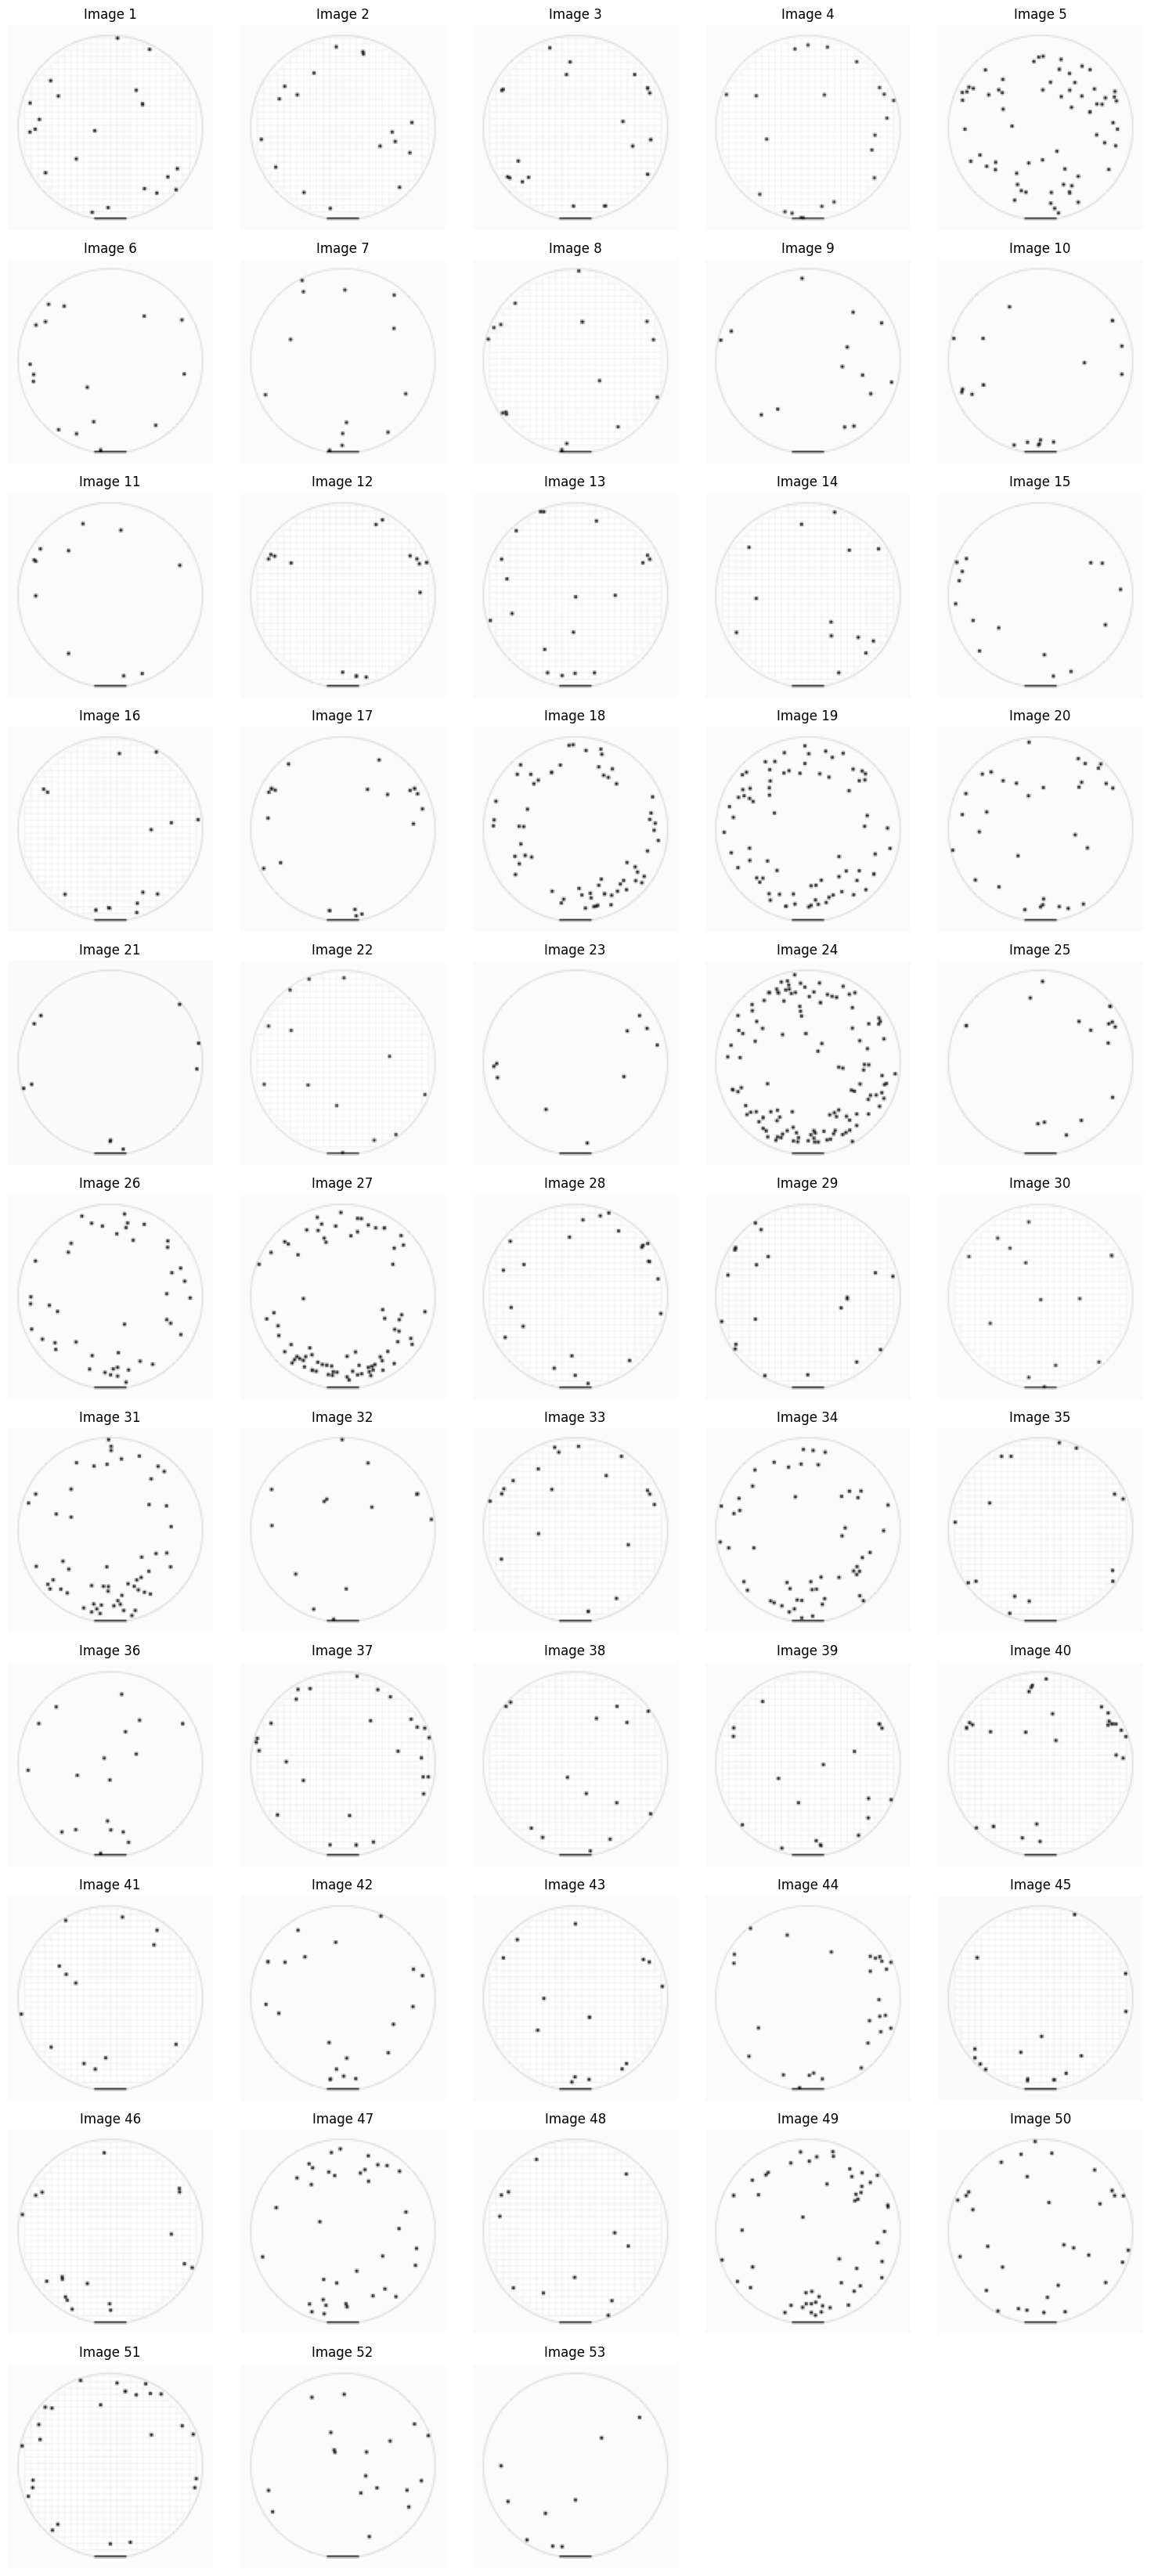

In [20]:
visualize_images(img_test)

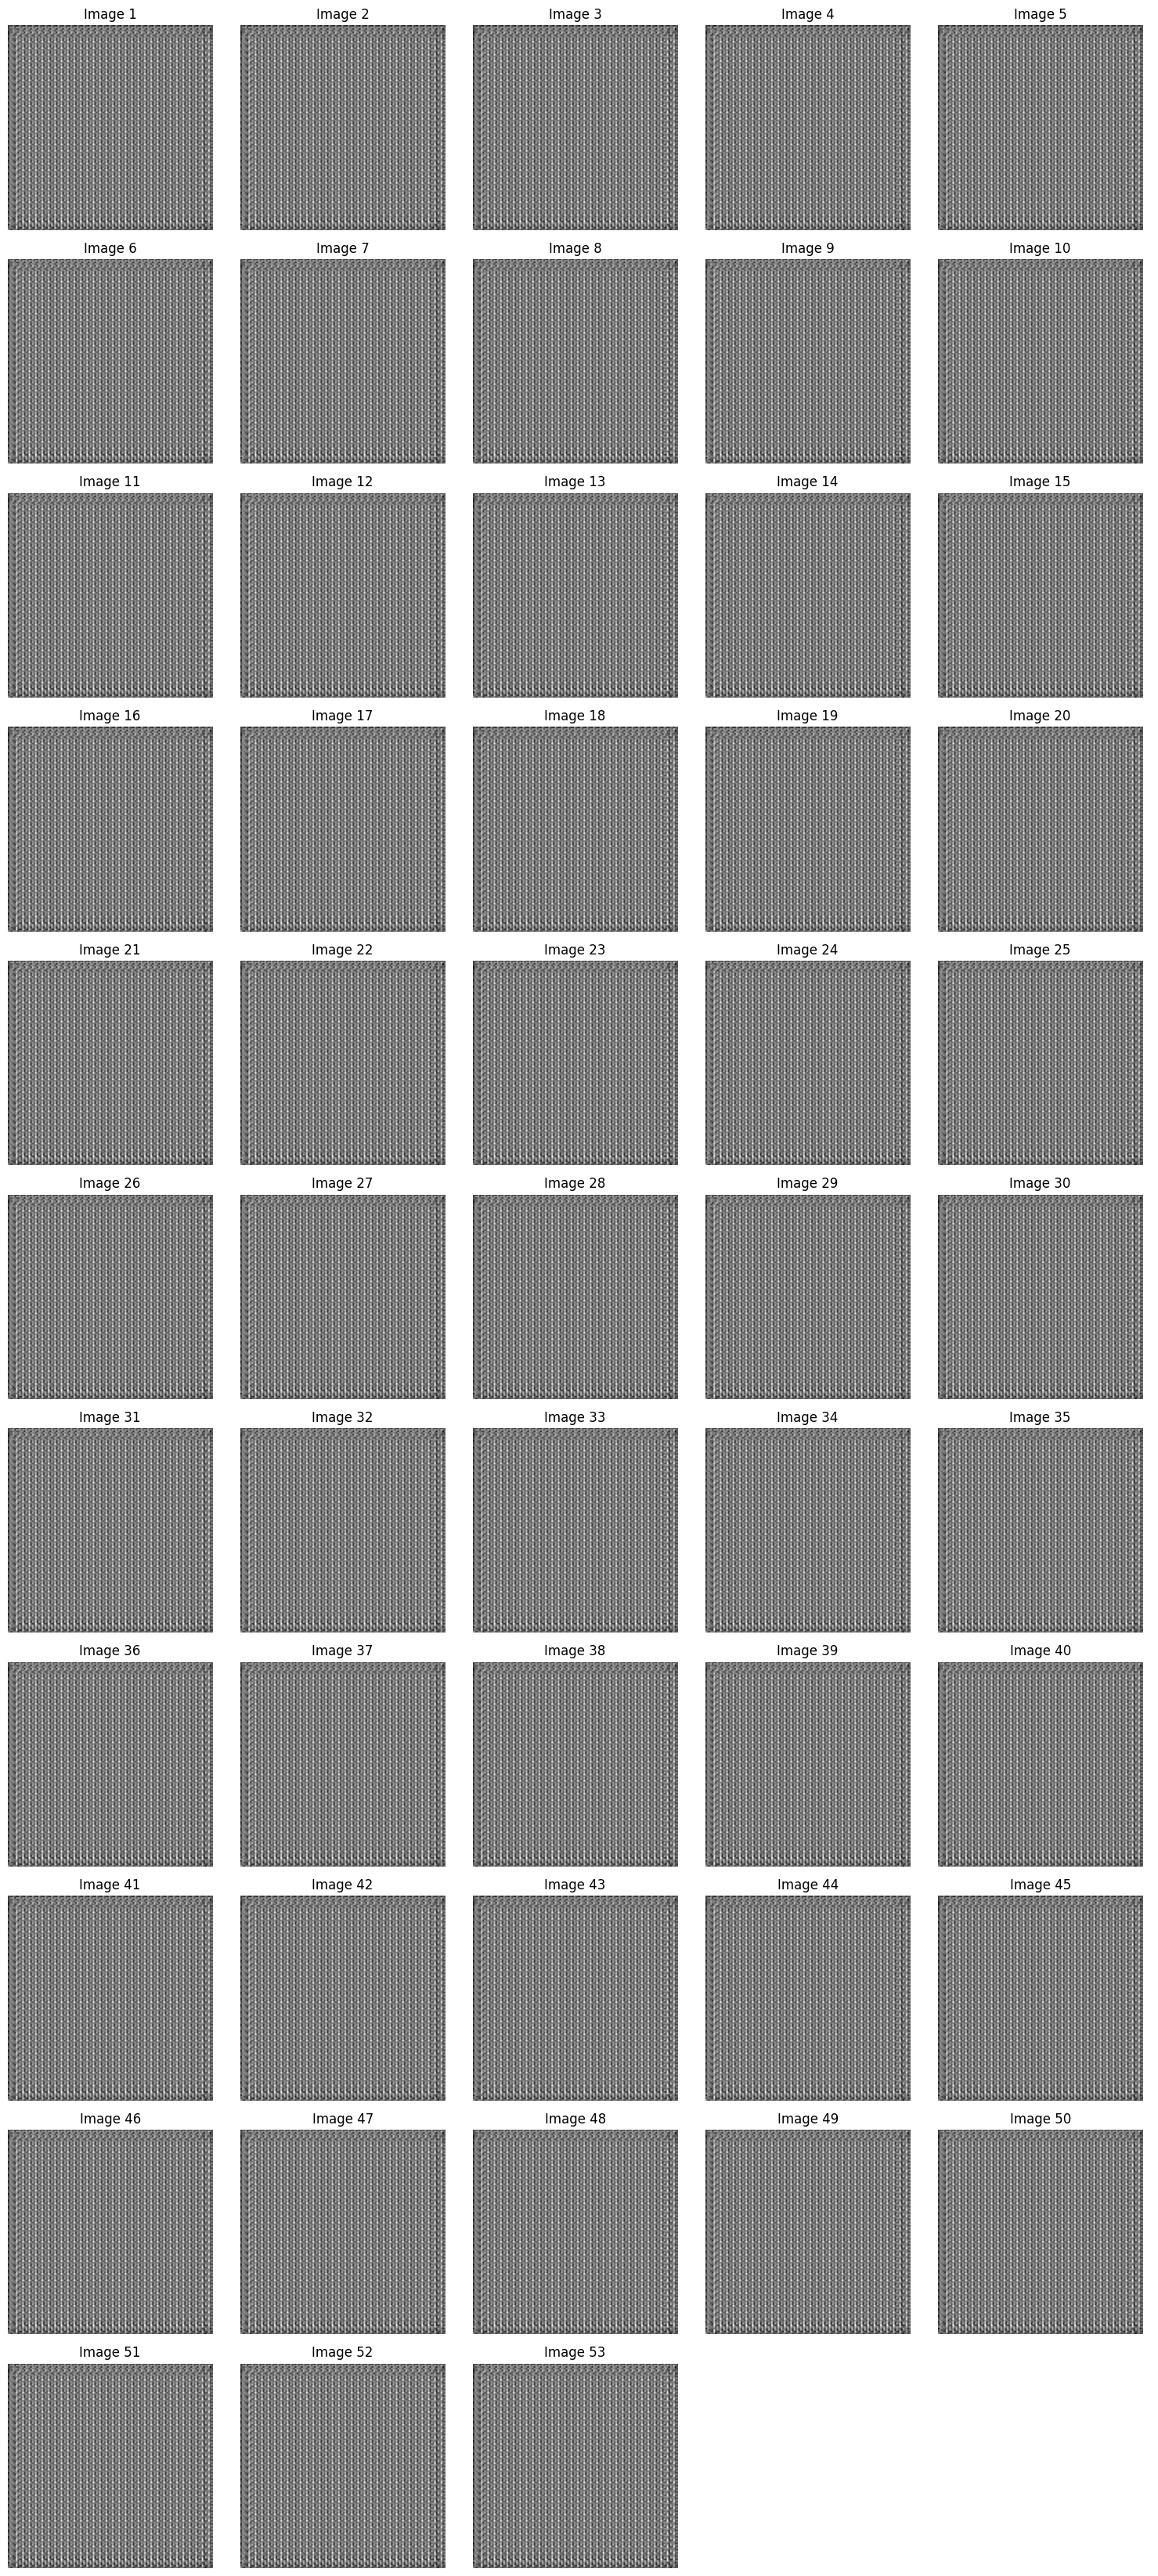

In [21]:
visualize_images(predicted_images)

Image → Scratch 분류 모델